# Univariate detector

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hydroeval as he
from datetime import datetime, timedelta
from pytz import timezone
from evaluation import roc_evals #self-developed codes

In [2]:
# Upload bridge_5 data
bridge_5 = pd.read_csv('../data/bridge5_classification.csv', index_col=0)
bridge_5.index = pd.to_datetime(bridge_5.index)
labels = bridge_5['2023-04-04':'2023-05-20']['class']
s = bridge_5['2023-04-04':'2023-05-20']['Bridge5']
data = s.values.reshape(-1, 1)

## KNNCAD Detector

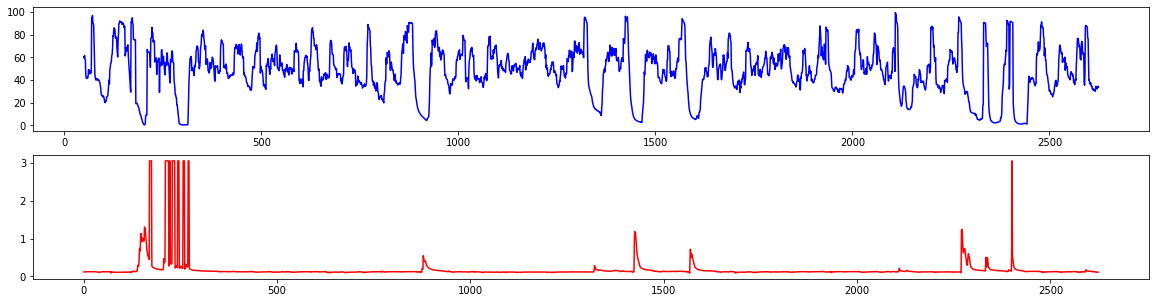

In [3]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import KNNDetector

#evaluation of anomalies scores

stream = StreamGenerator(data)
model = KNNDetector(k_neighbor=20)
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

    
#visualization of scores and data

fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')


#ROC evaluation at thresholds

thresholds = np.linspace(-1, 100, 100)
residuals=pd.DataFrame(scores)

KNN_roc_fpr_bridge5,KNN_roc_tpr_bridge5,KNN_auc=roc_fpr=roc_evals(thresholds, residuals,labels)
 
    


## Spectral Residual Detector

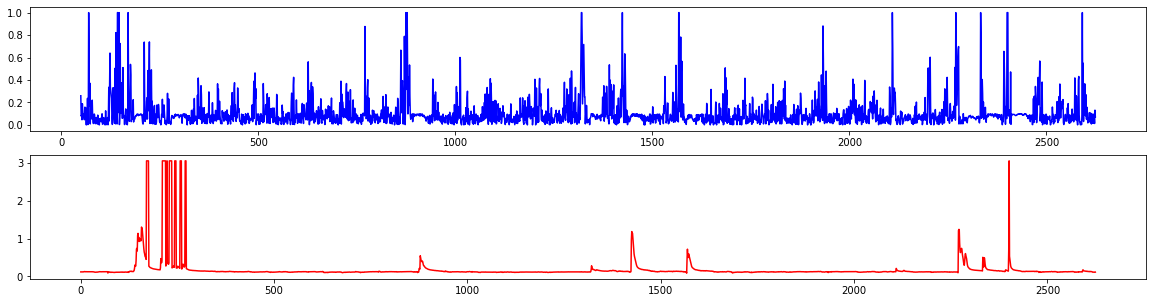

In [4]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import SRDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = SRDetector()
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(0, 1, 50)
residuals=pd.DataFrame(scores)


SRD_roc_fpr_bridge5,SRD_roc_tpr_bridge5,SRD_auc=roc_evals(thresholds, residuals,labels)



## Z-score Detector 


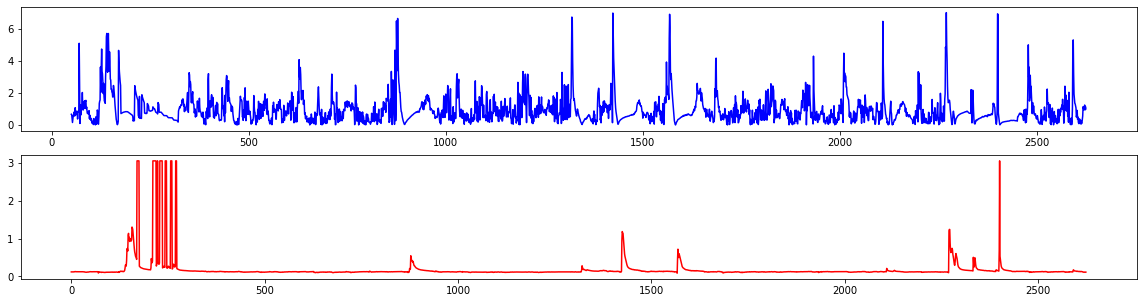

In [5]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import ZScoreDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = ZScoreDetector()
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)
    
#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(0, 10, 50)
residuals=pd.DataFrame(scores)

Z_roc_fpr_bridge5,Z_roc_tpr_bridge5,Z_auc=roc_evals(thresholds, residuals,labels)



## One-class SVM Detector

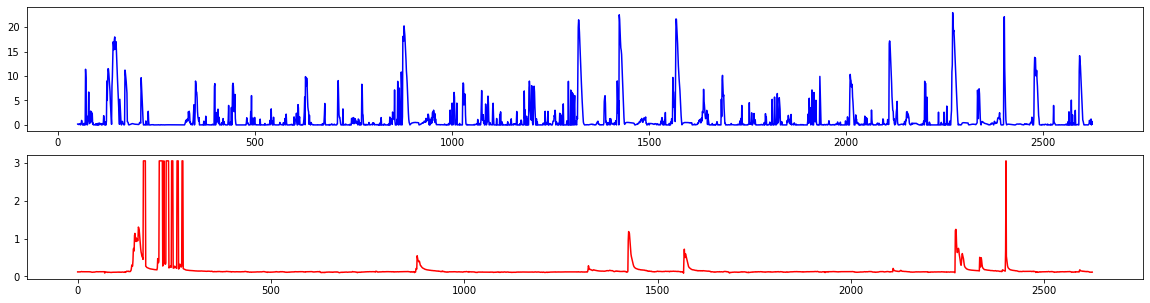

In [6]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import OCSVMDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = OCSVMDetector()
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(-5, 30, 10)
residuals=pd.DataFrame(scores)

SVM_roc_fpr_bridge5,SVM_roc_tpr_bridge5,SVM_auc=roc_evals(thresholds, residuals,labels)


## RRCF

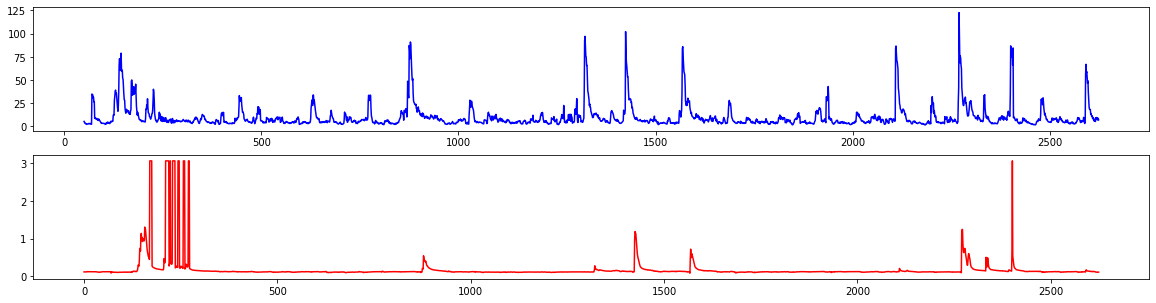

In [7]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import RrcfDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = RrcfDetector(num_trees=100, tree_size=128,window_len=50)
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(-5, 200, 2000)
residuals=pd.DataFrame(scores)

roc_rrfc_fpr_bridge5,roc_rrfc_tpr_bridge5,rrfc_auc=roc_evals(thresholds, residuals,labels)



# Kalman Filter 

In [8]:
#Upload residuals of kf (anomalies scores)
residuals=pd.read_csv('../data/residuals.csv',index_col=[0])
residuals.index=pd.to_datetime(residuals.index)
residuals=residuals['J_WLR18_COMB_HEMP'].resample('5min').mean().interpolate(method='nearest')
#Set labels of kf 
measurements=bridge_5.resample('5min').mean().interpolate(method='nearest')
B5=(bridge_5.iloc[bridge_5.index.get_indexer(measurements.index, method='nearest')]
                     .set_index(measurements.index))
labels=B5[residuals.index[0]:residuals.index[-1]]['class']


In [9]:
#ROC evaluation at thresholds
thresholds = np.linspace(-3, 8, 500)

roc_fpr_kf_bridge5,roc_tpr_kf_bridge5,kf_auc=roc_evals(thresholds, residuals,labels)


# KGE

In [10]:

# Load sensor data
s_2 = pd.read_csv('../data/bridge5_classification.csv', index_col=[0], converters={'0': pd.to_datetime})
sensor_2 = s_2.loc[s_2['class'], 'Bridge5']
sensor_outlier_2 = s_2.loc[~s_2['class'], 'Bridge5']

# Load model forecast data
forecast_model_result_kf = pd.read_csv('../data/h_j_kf_forecast.csv', index_col=[0], converters={'0': pd.to_datetime})

head_2_forecast_model_result_kf = forecast_model_result_kf['J_WLR18_COMB_HEMP']
head_2_forecast_model_result_all = pd.read_csv('../data/S2_forecast.csv', index_col=[0])
head_2_gauge_model_result_all = pd.read_csv('../data/S2.csv', index_col=[0])

# Convert index to DatetimeIndex
sensor_2.index = pd.to_datetime(sensor_2.index)
sensor_outlier_2.index = pd.to_datetime(sensor_outlier_2.index)
head_2_forecast_model_result_kf.index = pd.to_datetime(head_2_forecast_model_result_kf.index)
head_2_forecast_model_result_all.index = pd.to_datetime(head_2_forecast_model_result_all.index)
head_2_gauge_model_result_all.index = pd.to_datetime(head_2_gauge_model_result_all.index)

# Resample and interpolate sensor data
sensor_2_resample = sensor_2.resample('5min').mean().interpolate(method='nearest')

# Resample and interpolate simulation data
head_2_forecast_model_result_kf_resample = head_2_forecast_model_result_kf.resample('5min').mean().interpolate(method='nearest')
head_2_gauge_model_result_all_resample = head_2_gauge_model_result_all.resample('5min').mean().interpolate(method='nearest')
head_2_forecast_model_result_all_resample = head_2_forecast_model_result_all.resample('5min').mean().interpolate(method='nearest')

In [11]:
# Define date ranges
group1_range = slice('2023-04-05', '2023-04-15')
group2_range = slice('2023-04-16', '2023-05-01')
group3_range = slice('2023-05-02', '2023-05-20 12:00:00')

# Separate data for Group 1
evaluations_1 = sensor_2_resample[group1_range]
simulations_1_v1 = head_2_gauge_model_result_all_resample[group1_range]
simulations_1_v2 = head_2_forecast_model_result_all_resample[group1_range]
simulations_1_v3 = head_2_forecast_model_result_kf_resample[group1_range]

# Separate data for Group 2
evaluations_2 = sensor_2_resample[group2_range]
simulations_2_v1 = head_2_gauge_model_result_all_resample[group2_range]
simulations_2_v2 = head_2_forecast_model_result_all_resample[group2_range]
simulations_2_v3 = head_2_forecast_model_result_kf_resample[group2_range]

# Separate data for Group 3
evaluations_3 = sensor_2_resample[group3_range]
simulations_3_v1 = head_2_gauge_model_result_all_resample[group3_range]
simulations_3_v2 = head_2_forecast_model_result_all_resample[group3_range]
simulations_3_v3 = head_2_forecast_model_result_kf_resample[group3_range]

# Evaluate KGE for Group 1
kge_1_v1, r, alpha, beta = he.evaluator(he.kge, simulations_1_v1, evaluations_1)
kge_1_v2, r, alpha, beta = he.evaluator(he.kge, simulations_1_v2, evaluations_1)
kge_1_v3, r, alpha, beta = he.evaluator(he.kge, simulations_1_v3, evaluations_1)

# Evaluate KGE for Group 2
kge_2_v1, r, alpha, beta = he.evaluator(he.kge, simulations_2_v1, evaluations_2)
kge_2_v2, r, alpha, beta = he.evaluator(he.kge, simulations_2_v2, evaluations_2)
kge_2_v3, r, alpha, beta = he.evaluator(he.kge, simulations_2_v3, evaluations_2)

# Evaluate KGE for Group 3
kge_3_v1, r, alpha, beta = he.evaluator(he.kge, simulations_3_v1, evaluations_3)
kge_3_v2, r, alpha, beta = he.evaluator(he.kge, simulations_3_v2, evaluations_3)
kge_3_v3, r, alpha, beta = he.evaluator(he.kge, simulations_3_v3, evaluations_3)

# Creating dataset for KGE box plot
data_1 = np.concatenate([kge_1_v1,kge_2_v1,kge_3_v1])
data_2 = np.concatenate([kge_1_v2,kge_2_v2,kge_3_v2])
data_3 = np.concatenate([kge_1_v3,kge_2_v3,kge_3_v3])
box = [data_2,data_1,data_3]

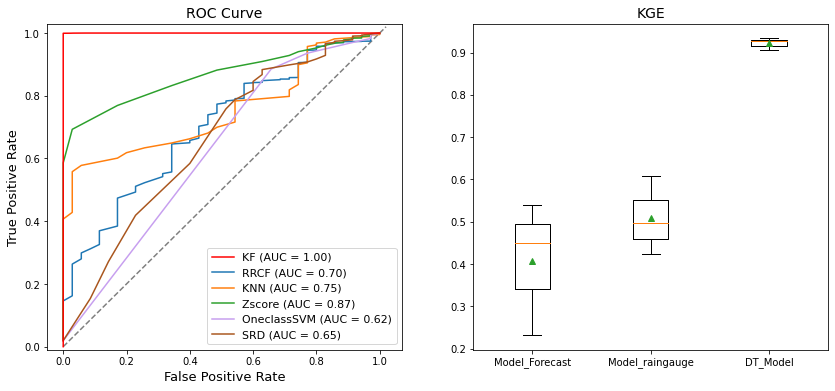

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve plot
ax[0].plot(roc_fpr_kf_bridge5, roc_tpr_kf_bridge5, color='r', label='KF (AUC = %0.2f)' % kf_auc, zorder=3)
ax[0].plot(roc_rrfc_fpr_bridge5, roc_rrfc_tpr_bridge5, label='RRCF (AUC = %0.2f)' % rrfc_auc)
ax[0].plot(KNN_roc_fpr_bridge5, KNN_roc_tpr_bridge5, label='KNN (AUC = %0.2f)' % KNN_auc)
ax[0].plot(Z_roc_fpr_bridge5, Z_roc_tpr_bridge5, label='Zscore (AUC = %0.2f)' % Z_auc)
ax[0].plot(SVM_roc_fpr_bridge5, SVM_roc_tpr_bridge5, color='#C79FEF', label='OneclassSVM (AUC = %0.2f)' % SVM_auc)
ax[0].plot(SRD_roc_fpr_bridge5, SRD_roc_tpr_bridge5, color='#A9561E', label='SRD (AUC = %0.2f)' % SRD_auc)

ax[0].set_xlabel('False Positive Rate', fontsize=13)
ax[0].set_ylabel('True Positive Rate', fontsize=13)
ax[0].set_title('ROC Curve', fontsize=14)
ax[0].set_ylim(-0.01, 1.03)
ax[0].plot([0, 1.02], [0, 1.02], linestyle='--', c='k', zorder=-1, alpha=0.5)
ax[0].legend(fontsize=11)

# KGE box plot
ax[1].set_title('KGE', fontsize=14)
ax[1].set_xticklabels(['Model_Forecast', 'Model_raingauge', 'DT_Model'])

# Creating plot
bp = ax[1].boxplot(box, showmeans=True)

# Show the plots
plt.show()


# Viualization of Noise detection

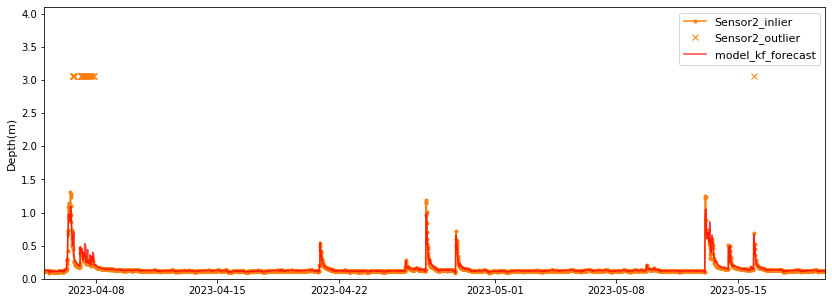

In [13]:
start = datetime(2023, 4, 5, tzinfo=timezone('US/Central'))
end = datetime(2023, 5, 20, tzinfo=timezone('US/Central'))

plt.figure(figsize=(14, 5))
ax = plt.gca()

ax.set_xlim(start, end)
ax.set_ylim(0, 4.1)

ax.plot(sensor_2, 'tab:orange', label='Sensor2_inlier', marker='.')
ax.plot(sensor_outlier_2, 'tab:orange', label='Sensor2_outlier', linestyle='None', marker='x')
ax.plot(head_2_forecast_model_result_kf, 'r', label='model_kf_forecast', alpha=0.75, zorder=4)

ax.legend(fontsize=11)
ax.set_ylabel('Depth(m)', fontsize=11)

plt.show()